In [1]:
import pymc4 as pm4
import numpy as np
import arviz as az
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pprint import pprint
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transformed_log_prob,
)

import pymc3 as pm3
import theano.tensor as tt

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float32
plt.style.use("arviz-darkgrid")

np.random.seed(42)
pm3.set_tt_rng(42)
tf.random.set_seed(42)

In [2]:
mu = np.zeros(2, dtype=np.float32)
cov = np.array([[1, 0.8], [0.8, 1]], dtype=np.float32)
data = np.random.multivariate_normal(mu, cov, size=10000)

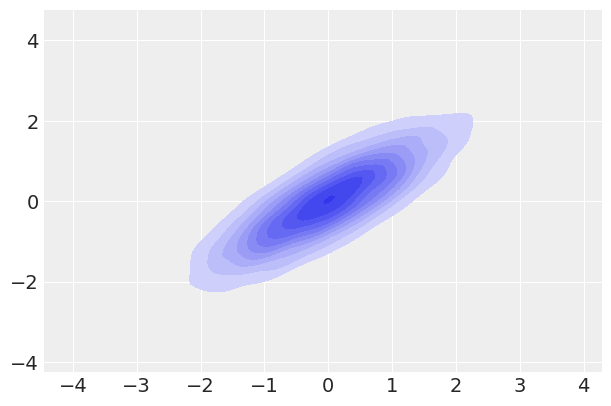

In [3]:
sns.kdeplot(data[:, 0], data[:, 1], shade=True, shade_lowest=False);

## PyMC4

In [4]:
@pm4.model
def model():
    density = yield pm4.MvNormalCholesky("density", loc=mu, scale_tril=cov)

In [5]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
mean_field = pm4.fit(model(), num_steps=40000, optimizer=opt)

pymc4_samples = mean_field.approximation.sample(10000).posterior['model/density'].values
pymc4_samples = np.squeeze(pymc4_samples, axis=0)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


## TFP

In [6]:
model = tfd.JointDistributionSequential(
    [tfd.MultivariateNormalTriL(loc=mu, scale_tril=cov)]
)

joint_log_prob = lambda *x: model.log_prob(x)

In [7]:
# Transformations to bounded space
unconstraining_bijectors = [tfb.Identity()]

posterior = make_transformed_log_prob(
    joint_log_prob,
    unconstraining_bijectors,
    direction="forward",
    enable_bijector_caching=False,
)

In [8]:
def build_mf_advi():
    parameters = model.sample()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter.shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f"meanfield_{i}_loc",
            dtype=dtype,
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(1, dtype=dtype)),
            tfb.Softplus(),  # For positive values of scale
            name=f"meanfield_{i}_scale",
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)


mean_field = build_mf_advi()

In [9]:
@tf.function(autograph=False)
def run_approximation():
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        posterior,
        surrogate_posterior=mean_field,
        optimizer=opt,
        num_steps=40000,
    )
    return elbo_loss


elbo_loss = run_approximation()

In [10]:
tfp_samples = mean_field.sample(10000)[0]

## PyMC3

In [11]:
with pm3.Model() as model:
    density = pm3.MvNormal("density", mu=mu, cov=cov, shape=2)

In [12]:
with model:
    mean_field = pm3.fit(n=40000, obj_optimizer=pm3.adam())

pymc3_samples = mean_field.sample(10000)["density"]

Finished [100%]: Average Loss = 0.52567


## Plotting results

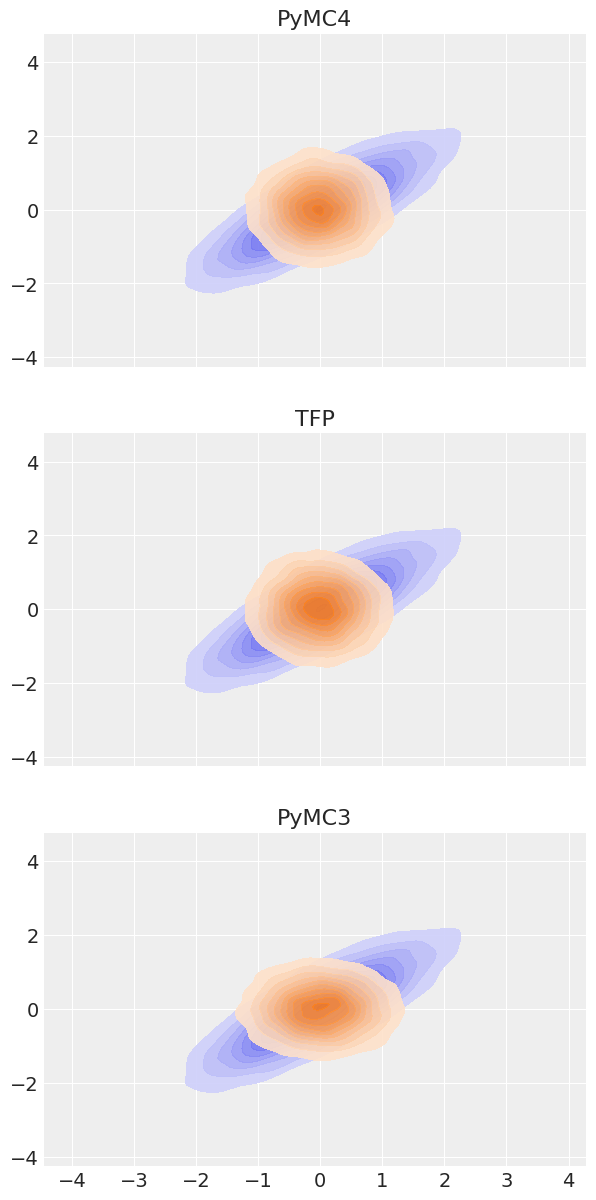

In [13]:
f, axes = plt.subplots(3, 1, figsize=(7, 15), squeeze=False, sharex=True)
rows = [n for n in range(0, 3)]
titles = ["PyMC4", "TFP", "PyMC3"]
samples = [
    (pymc4_samples[:, 0], pymc4_samples[:, 1]),
    (tfp_samples[:, 0].numpy(), tfp_samples[:, 1].numpy()),
    (pymc3_samples[:, 0], pymc3_samples[:, 1])
]

# Plot
for row, title, sample in zip(rows, titles, samples):
    ax = sns.kdeplot(
        data[:, 0],
        data[:, 1],
        shade=True,
        shade_lowest=False,
        alpha=0.9,
        ax=axes[row, 0],
    )
    ax.set_title(title)
    sns.kdeplot(
        sample[0],
        sample[1],
        shade=True,
        shade_lowest=False,
        alpha=0.9,
        ax=axes[row, 0],
    )


In [14]:
%load_ext watermark

In [15]:
%watermark -v -m --iversions

tensorflow_probability 0.11.0-dev20200616
pymc4                  4.0a2
numpy                  1.18.5
arviz                  0.8.3
tensorflow             2.3.0-dev20200616
pymc3                  3.9.0
seaborn                0.10.1
CPython 3.7.7
IPython 7.15.0

compiler   : Clang 11.0.0 (clang-1100.0.33.17)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
